### Age prediction with regression method

This code snippet sets up a convolutional neural network for age prediction based on facial features. It leverages the VGGFace model with SENet50 architecture, fine-tuning the last layers while keeping the initial ones frozen to preserve pre-trained facial feature detection capabilities. The network includes a fully connected layer, batch normalization, and dropout for regularization, followed by a dense layer for regression output. It uses Adam optimizer with a low learning rate for fine-tuning, aiming for minimal mean squared error. The model is trained with callback functions for saving the best model and adjusting the learning rate on validation loss plateaus, showcasing an advanced approach to age prediction with deep learning.

In [1]:
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline
import matplotlib.pyplot as plt
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout2D, SeparableConv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

For managing large datasets efficiently and minimizing memory usage, we utilize data generators. These generators stream data in batches directly to the model during training, enabling real-time data augmentation and improving model performance without overwhelming system resources.

In [2]:
# data generator method
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, load_from, batch_size=32, dim=(224,224), n_channels=3,
                 shuffle=True, preprocessing=None):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.load_from = load_from
        self.preprocessing = preprocessing
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Generates data containing batch_size samples
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img_path = os.path.join(self.load_from, ID)
            img = load_img(img_path, target_size=self.dim)  # This is a PIL image
            img = img_to_array(img)  # Convert to numpy array
            img = self.preprocessing(img) if self.preprocessing else img  # Apply preprocessing
            X[i,] = img

            label = ID.split('_')[0]
            y[i] = int(label)

        return X, y/116


In [3]:
#data gen config
load_from_train = 'data/train/'
load_from_val = 'data/test/'

def preprocess_input_vggface(x):
    x = np.array(x, dtype=np.float32)
    x[..., 0] -= 93.5940  # Subtract the mean red value
    x[..., 1] -= 104.7624 # Subtract the mean green value
    x[..., 2] -= 129.1863 # Subtract the mean blue value
    return x

# Parameters
batch_size = 32
params = {'dim': (224, 224),
          'batch_size': batch_size,
          'n_channels': 3,
          'shuffle': True,
          'preprocessing': preprocess_input_vggface}

ids_train = os.listdir(load_from_train) # IDs for training
ids_val = os.listdir(load_from_val) # IDs for validation

training_generator = DataGenerator(list_IDs = ids_train, load_from = load_from_train, **params)
validation_generator = DataGenerator(list_IDs = ids_val, load_from = load_from_val, **params)

### Build the model with VGGFace

In [4]:
# Load VGGFace model
# Creating a base model with SENet50
base_model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True

x = base_model.output
# Fully connected system
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Make sure to call AlphaDropout on `x`
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
#, kernel_initializer='he_uniform'
x = BatchNormalization()(x)
# Output layer for regression with 1 neuron (no activation function is used for regression)
predictions = Dense(1)(x)  # Note: No activation function

# This is the model we will train for regression
model = Model(inputs=base_model.input, outputs=predictions)

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate might be beneficial for fine-tuning

# Compile the model for regression with Mean Squared Error loss
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])


In [5]:
# Create directory for saving models
os.makedirs('saved_models1', exist_ok=True)

# Adjusted filename pattern for regression
filename = 'saved_models1/epoch-{epoch:02d}-val_loss-{val_loss:.4f}-val-{loss:.4f}.h5'

# ModelCheckpoint to save model based on validation loss
checkpoint = ModelCheckpoint(filename, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# ReduceLROnPlateau to reduce learning rate when validation loss plateaus
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, verbose=1, mode='auto', min_delta=0.0001, min_lr=0.0001)

# Callbacks list
callbacks_list = [checkpoint, reduceLROnPlat]

In [6]:
# Fit the model using the Dataset
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = callbacks_list
)

Epoch 1/20
592/592 [==============================] - ETA: 0s - loss: 0.8240 - mean_squared_error: 0.8240 - mean_absolute_error: 0.7067
Epoch 1: val_loss improved from inf to 0.21245, saving model to saved_models1\epoch-01-val_loss-0.2125-val-0.8240.h5
592/592 [==============================] - 123s 172ms/step - loss: 0.8240 - mean_squared_error: 0.8240 - mean_absolute_error: 0.7067 - val_loss: 0.2125 - val_mean_squared_error: 0.2125 - val_mean_absolute_error: 0.3645 - lr: 1.0000e-04
Epoch 2/20
592/592 [==============================] - ETA: 0s - loss: 0.3642 - mean_squared_error: 0.3642 - mean_absolute_error: 0.4794
Epoch 2: val_loss improved from 0.21245 to 0.13525, saving model to saved_models1\epoch-02-val_loss-0.1353-val-0.3642.h5
592/592 [==============================] - 64s 108ms/step - loss: 0.3642 - mean_squared_error: 0.3642 - mean_absolute_error: 0.4794 - val_loss: 0.1353 - val_mean_squared_error: 0.1353 - val_mean_absolute_error: 0.2927 - lr: 1.0000e-04
Epoch 3/20
592/592 

Epoch 18/20
592/592 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0611
Epoch 18: val_loss improved from 0.00428 to 0.00396, saving model to saved_models1\epoch-18-val_loss-0.0040-val-0.0062.h5
592/592 [==============================] - 67s 113ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0611 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0460 - lr: 1.0000e-04
Epoch 19/20
592/592 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0595
Epoch 19: val_loss improved from 0.00396 to 0.00392, saving model to saved_models1\epoch-19-val_loss-0.0039-val-0.0060.h5
592/592 [==============================] - 73s 123ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0595 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0455 - lr: 1.0000e-04
Epoch 20/20


##### Example of a photo of an old lady who is 100 years old

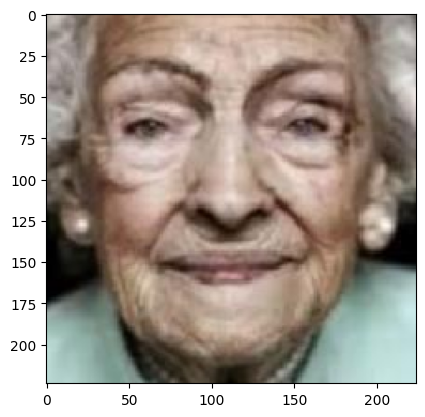

1/1 [==============================] - 0s 98ms/step
Predicted Age: 97.9669234752655


In [33]:
image_path = 'data/test/100_1_0_20170119212053665.jpg.chip.jpg'
image = load_img(image_path, target_size=(224, 224))  # Ensure the target size matches your model input
plt.imshow(image)
plt.show()
image = img_to_array(image)  # Convert the image to a numpy array
image = preprocess_input_vggface(image)  # Apply your custom preprocessing
image = np.expand_dims(image, axis=0)  # Add a batch dimension
predicted_age = model.predict(image)
print("Predicted Age:", predicted_age[0][0]*116)